# 1d - Beispiel zum Assembling

Wir betrachten das Assembling für den eindimensionalen Fall anhand des Randwertproblems

$$\begin{split}-u''(x) & = 1\quad \text{für}\ x\in (0,1)\\
u(0) = u(1) & = 0.\end{split}$$

Die analytische Lösung kann einfach durch zweimaliges Integrieren berechnet werden.

In [1]:
def uanalytic(x):
    return -0.5*x*(x-1)

Die zu betrachtende schwache Gleichung ist gegeben durch

$$\int_0^1u'(x) v'(x)\, dx = \int_0^1 1 v(x)\,dx \quad \text{für alle}\ v\in V_h\subset H_0^1(0,1).$$

## Erste Ordnung

Da die Bilinearform 

Im Fall von finiten Elemente erster Ordnung folgt für die Diskretisierung der Bilinearform

$$\begin{split} A: V_h \times V_h & \to \mathbb{R}\\
(u,v) & \mapsto A(u,v) := \int_0^1u'(x) v'(x)\, dx\end{split}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Elementsteiffigkeitsmatrix
order = 1
Ae = np.array([[1,-1],[-1,1]])

# Zerlegung des Gebiets
n=5;a=0;b=1
xi = np.linspace(a,b,n+1)
h = xi[1:]-xi[:-1]

# lokal - global mapping
N = n+1
T = np.array([[i,i+1] for i in range(N)])

# Globale Steiffigkeitsmatrix
A = np.zeros((N,N))

# Loop über Elemente (Assembling)
for i in range(n):
    # Compute Ae falls der Integrand ortsabhängig ist.
    for j in range(order+1):
        for k in range(order+1):
            A[T[i,j],T[i,k]] += Ae[j,k]/h[i]
A

array([[ 5., -5.,  0.,  0.,  0.,  0.],
       [-5., 10., -5.,  0.,  0.,  0.],
       [ 0., -5., 10., -5.,  0.,  0.],
       [ 0.,  0., -5., 10., -5.,  0.],
       [ 0.,  0.,  0., -5., 10., -5.],
       [ 0.,  0.,  0.,  0., -5.,  5.]])

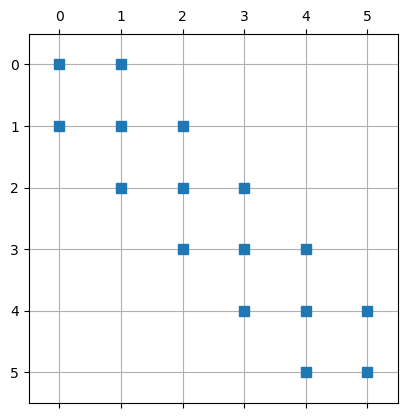

In [3]:
plt.spy(A,markersize=7,)
plt.grid()
plt.show()

Im allgemeinen Fall, dass die Bilinearform einen ortsabhängigen Koeffizienten hat

$$A(u,v) = \int_0^1a(x)\, u'(x) v'(x)\, dx,$$

muss in jedem Element die Elementmatrix integriert werden. Am Beispiel der Linearform

$$\begin{split} f: V_h & \to \mathbb{R}\\
v & \mapsto f(v) := \int_0^1 1 v(x)\, dx\end{split}$$

sei das Vorgehen illustriert.

In [5]:
from scipy.integrate import fixed_quad
# Referenz Elementfunktionen
def phi(t,i):
    if i == 0:
        return 1-t
    else:
        return t

# Rechteseite der DGL
def func(x):
    return np.ones_like(x)

# Koordinaten Transformation
def sigma(t,i):
    return xi[i]+t*h[i]

# Globale Vektor der Linearform
f = np.zeros(N)

# Loop über Elemente (Assembling)
for i in range(n):
    # berechne lokaler Elementvektor
    fe = [np.sum([fixed_quad(lambda t: func(sigma(t,i))*phi(t,j), xi[k],xi[k+1],n=2*order)[0]
                  for k in range(n)])
          for j in range(order+1)]
    for j in range(order+1):
        f[T[i,j]] += h[i]*fe[j]
f

array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])

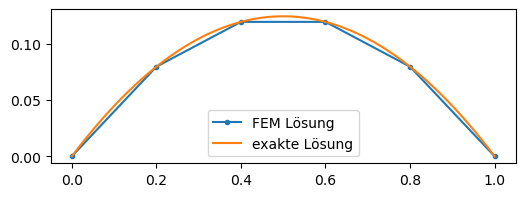

In [6]:
ui = np.zeros_like(xi)
ui[1:-1] = np.linalg.solve(A[1:-1,1:-1],f[1:-1])

xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xi,ui,'.-',label='FEM Lösung')
ax.plot(xp,uanalytic(xp),label='exakte Lösung')
ax.legend()
plt.show()

## Zweite Ordnung Lagrange Basis Funktionen

In [7]:
from sympy.abc import x as symbx
from sympy import lambdify

Betrachten wir das Vorgehen unter Verwendung von Lagrange Polynome zweiter Ordnung als Basisfunktionen.

In [8]:
order = 2

$$L(x) = \prod_{\overset{k=0}{k\not= j}}^m \frac{x-x_k}{x_j-x_k}$$



In [9]:
def lagrangePoly(x,j,order):
    xi = np.linspace(0,1,order+1)
    J = np.delete(np.arange(order+1),j)
    return np.product([(x-xi[i])/(xi[j]-xi[i]) for i in J],axis=0)

Für die Beispielgleichung können wir die Elementmatrix wiederum vorab berechnen:

In [15]:
Ae = np.array([[np.sum([
    fixed_quad(lambdify(symbx,lagrangePoly(symbx,i,order).diff()*lagrangePoly(symbx,j,order).diff()),
               xi[k],xi[k+1],n=2*order)[0]
    for k in range(n)])
    for i in range(order+1)] for j in range(order+1)],dtype=float)
Ae

array([[ 2.33333333, -2.66666667,  0.33333333],
       [-2.66666667,  5.33333333, -2.66666667],
       [ 0.33333333, -2.66666667,  2.33333333]])

Die Zerlegung des Gebiets ist gegeben durch

In [16]:
# Zerlegung des Gebiets
n=5;a=0;b=1
xi = np.linspace(a,b,n+1)
h = xi[1:]-xi[:-1]

# lokal - global mapping
N = n+1
T = np.array([[i,i+1,i+2] for i in range(0,2*n,2)])
T

array([[ 0,  1,  2],
       [ 2,  3,  4],
       [ 4,  5,  6],
       [ 6,  7,  8],
       [ 8,  9, 10]])

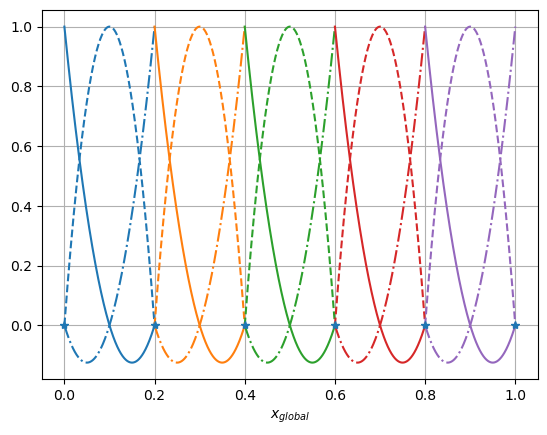

In [17]:
col = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
for k in range(n):
    plt.plot(xi[k]+ h[k]*xp, lagrangePoly(xp, 0, 2),'-',c=col[k%5]) # lokale Basisfunktion 0 an globalen Kooridnaten
    plt.plot(xi[k]+ h[k]*xp, lagrangePoly(xp, 1, 2),'--',c=col[k%5])# lokale Basisfunktion 1
    plt.plot(xi[k]+ h[k]*xp, lagrangePoly(xp, 2, 2),'-.',c=col[k%5])# lokale Basisfunktion 2
plt.plot(xi,np.zeros_like(xi),'*')
plt.xlabel('$x_{global}$')
plt.grid()
plt.show()

In [18]:
# Globale Steiffigkeitsmatrix
A = np.zeros((2*n+1,2*n+1))

# Loop über Elemente (Assembling)
for i in range(n):
    for j in range(order+1):
        for k in range(order+1):
            A[T[i,j],T[i,k]] += Ae[j,k]/h[i]

Matrix mit allen Freiheitsgrade:

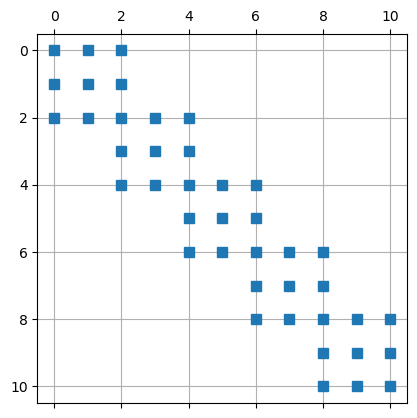

In [19]:
plt.spy(A,markersize=7,)
plt.grid()
plt.show()

Matrix mit den freien Freiheitsgrade:

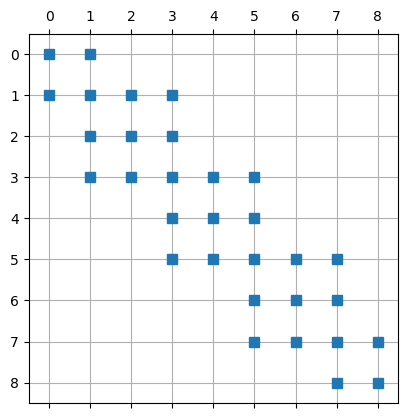

In [20]:
plt.spy(A[1:-1,1:-1],markersize=7,)
plt.grid()
plt.show()

Für die Linearform folgt analog:

In [21]:
from scipy.integrate import quad

# Rechteseite der DGL
def func(x):
    return np.ones_like(x)

# Koordinaten Transformation
def sigma(t,i):
    return xi[i]+t*h[i]

def invsigma(x,i):
    return (x-xi[i])/h[i]

# Globale Vektor der Linearform
f = np.zeros(2*n+1)

# Loop über Elemente (Assembling)
for i in range(n):
    # berechne lokaler Vektor
    fe = [np.sum([fixed_quad(lambda t: func(sigma(t,i))*lagrangePoly(t,j,order), xi[k],xi[k+1],n=2*order)[0]
                  for k in range(n)])
          for j in range(order+1)]
    for j in range(order+1):
        f[T[i,j]] += h[i]*fe[j]
f

array([0.03333333, 0.13333333, 0.06666667, 0.13333333, 0.06666667,
       0.13333333, 0.06666667, 0.13333333, 0.06666667, 0.13333333,
       0.03333333])

und damit die Lösung

In [22]:
ui = np.zeros(2*n+1)
ui[1:-1] = np.linalg.solve(A[1:-1,1:-1],f[1:-1])
ui

array([0.   , 0.045, 0.08 , 0.105, 0.12 , 0.125, 0.12 , 0.105, 0.08 ,
       0.045, 0.   ])

Um die Lösung präzise darstellen zu können, muss die Visualisierung angepasst werden. Wir benutzen nicht mehr die stückweise lineare Interpolation der `plt.plot` Funktion. Die Lösung ist gegeben als Linearkombination der **globalen** Basisfunktionen. Diese können wir mit Hilfe der drei **lokalen** Basisfunktionen darstellen:

In [23]:
def visu(x,ui):
    res = np.zeros_like(x)
    for i in range(n):
        if i < n-1:
            ind = (xi[i]<=x)*(x<xi[i+1])
        else:
            ind = (xi[i]<=x)*(x<=xi[i+1])
        for j in range(order+1):
            res[ind] += ui[T[i,j]]*lagrangePoly(invsigma(x[ind],i),j,order)
    return res

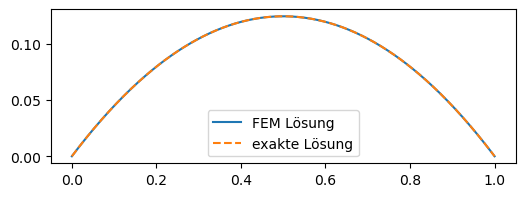

In [24]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui),'-',label='FEM Lösung')
ax.plot(xp,uanalytic(xp),'--',label='exakte Lösung')
ax.legend()
plt.show()

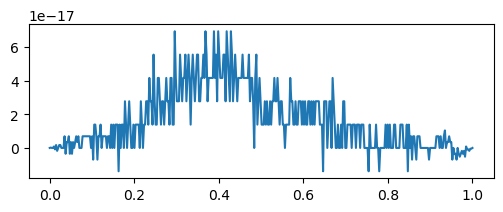

In [25]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui)-uanalytic(xp),'-')
plt.show()

Die analytische Lösung ist ein quadratisches Polynom, weshalb die numerische Lösung auch exakt ist.

## Zweite Ordnung hierarchische Basis Funktionen

Anstelle von drei Lagrange Polyome können wir auch den Ansatz, wie in `ngsolve` verwendet, anwenden. Die Basisfunktionen bauen rekursive auf den Basisfunktionen niedriger Ordnung auf. Daher haben wir für `order=2` die drei lokalen Basisfunktionen

$$\begin{split}
\varphi_0(x) & = 1-x\\
\varphi_1(x) & = x\\
\varphi_2(x) & = x\,(1-x).\end{split}$$

In [26]:
from sympy.abc import x as symbx
from sympy import lambdify

In [27]:
order = 2

In [28]:
def myshape(x,j):
    if j == 0:
        return 1-x
    elif j == 1:
        return x
    else: 
        return x*(1-x)

Als Zerlegung für das Gebiet nutzen wir nicht äquidistante Intervalle.

In [29]:
# Zerlegung des Gebiets
n=5;a=0;b=1
xi = a+(b-a)*(np.arctan(np.linspace(-1,1,n+1))-np.arctan(-1))/(2*np.arctan(1))
h = xi[1:]-xi[:-1]

Das lokal - global Mapping ist nun leicht unterschiedlich. Globale Basisfunktionen setzen sich aus den beiden ersten Basisfunktionen zusammen. Entsprechend gilt:

In [30]:
# lokal - global mapping
N = n+1
T = np.array([[i,i+1,n+1+i] for i in range(0,n)])
T

array([[ 0,  1,  6],
       [ 1,  2,  7],
       [ 2,  3,  8],
       [ 3,  4,  9],
       [ 4,  5, 10]])

Die freien Freiheitsgrade sind in dem Fall gegeben durch

In [31]:
freedofs = np.ones(np.max(T)+1,dtype=bool)
freedofs[0] = False # ohne Punkt 0 (linke Gebietsgrenze)
freedofs[5] = False # ohne Punkt 6 (rechte Gebietsgrenze)
freedofs

array([False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True])

Für die Intervall Längen gilt:

In [32]:
h

array([0.15595826, 0.21837582, 0.25133183, 0.21837582, 0.15595826])

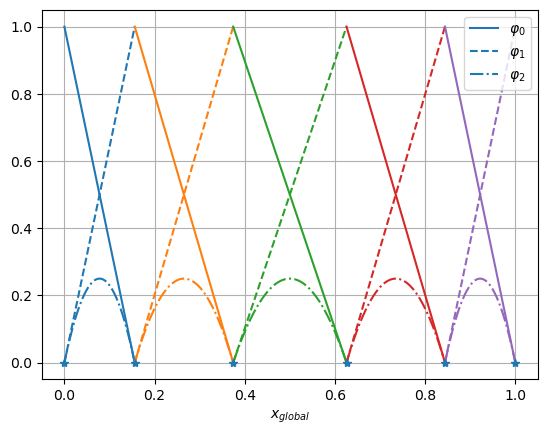

In [33]:
col = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
for k in range(n):
    plt.plot(xi[k]+ h[k]*xp, myshape(xp, 0),'-',c=col[k%5]) # lokale Basisfunktion 0 an globalen Kooridnaten
    plt.plot(xi[k]+ h[k]*xp, myshape(xp, 1),'--',c=col[k%5])# lokale Basisfunktion 1
    plt.plot(xi[k]+ h[k]*xp, myshape(xp, 2),'-.',c=col[k%5])# lokale Basisfunktion 2
plt.legend([r'$\varphi_0$',r'$\varphi_1$',r'$\varphi_2$'],loc=1)
plt.plot(xi,np.zeros_like(xi),'*')
plt.xlabel('$x_{global}$')
plt.grid()
plt.show()

In [36]:
Ae = np.array([[np.sum([fixed_quad(lambdify(symbx,myshape(symbx,i).diff()*myshape(symbx,j).diff()),
                                    xi[k],xi[k+1],n=2*order)[0]
                        for k in range(n)])
                for i in range(order+1)] for j in range(order+1)],dtype=float)

Für die Elementsteifigkeitsmatrix folgt

In [37]:
np.round(Ae,4)

array([[ 1.    , -1.    ,  0.    ],
       [-1.    ,  1.    , -0.    ],
       [ 0.    , -0.    ,  0.3333]])

mit obiger Zerlegung:

In [38]:
# Globale Steiffigkeitsmatrix
A = np.zeros((2*n+1,2*n+1))

# Loop über Elemente (Assembling)
for i in range(n):
    for j in range(order+1):
        for k in range(order+1):
            A[T[i,j],T[i,k]] += Ae[j,k]/h[i]

Matrix mit allen Freiheitsgrade:

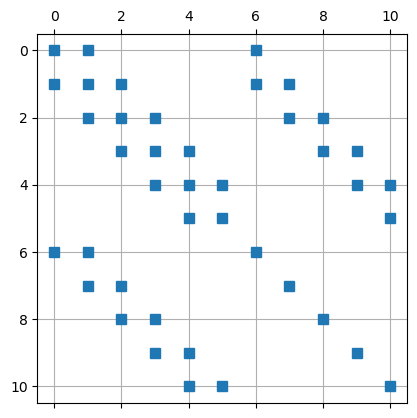

In [39]:
plt.spy(A,markersize=7,)
plt.grid()
plt.show()

Matrix mit den freien Freiheitsgrade:

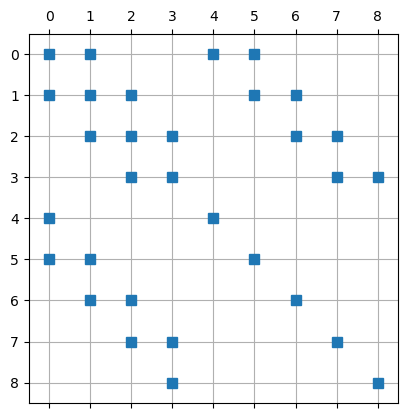

In [40]:
plt.spy(A[np.ix_(freedofs,freedofs)],markersize=7,)
plt.grid()
plt.show()

In [46]:
# Rechteseite der DGL
def func(x):
    return np.ones_like(x)

# Koordinaten Transformation
def sigma(t,i):
    return xi[i]+t*h[i]

def invsigma(x,i):
    return (x-xi[i])/h[i]

# Globale Vektor der Linearform
f = np.zeros(2*n+1)

# Loop über Elemente (Assembling)
for i in range(n):
    # berechne lokaler Vektor
    fe = np.array([np.sum([fixed_quad(lambda t: func(sigma(t,i))*myshape(t,j), xi[k],xi[k+1],n=2*order)[0]
                           for k in range(n)])
                   for j in range(order+1)])
    #for j in range(order+1):
    f[T[i]] += h[i]*fe
f

array([0.07797913, 0.18716704, 0.23485383, 0.23485383, 0.18716704,
       0.07797913, 0.02599304, 0.03639597, 0.04188864, 0.03639597,
       0.02599304])

Lösung des linearen Gleichungssystems für die freien Freiheitsgrade

In [47]:
ui = np.zeros(2*n+1)
ui[freedofs] = np.linalg.solve(A[np.ix_(freedofs,freedofs)],f[freedofs])
ui

array([0.        , 0.06581764, 0.11710404, 0.11710404, 0.06581764,
       0.        , 0.01216149, 0.023844  , 0.03158385, 0.023844  ,
       0.01216149])

In [48]:
def visu(x,ui):
    res = np.zeros_like(x)
    for i in range(n):
        if i < n-1:
            ind = (xi[i]<=x)*(x<xi[i+1])
        else:
            ind = (xi[i]<=x)*(x<=xi[i+1])
        for j in range(order+1):
            # neue lokale Basis
            res[ind] += ui[T[i,j]]*myshape(invsigma(x[ind],i),j)
    return res

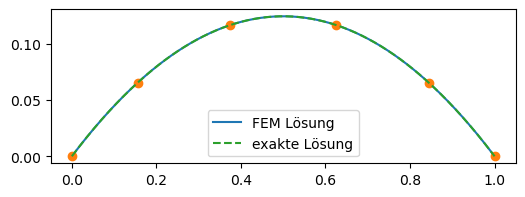

In [49]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui),'-',label='FEM Lösung')
ax.plot(xi,visu(xi,ui),'o')
ax.plot(xp,uanalytic(xp),'--',label='exakte Lösung')
ax.legend()
plt.show()

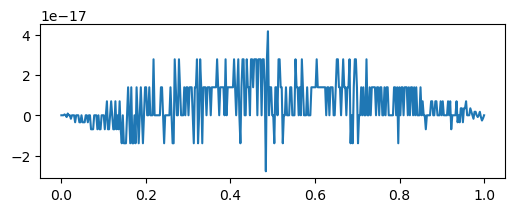

In [50]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui)-uanalytic(xp),'-')
plt.show()